Logistic Regression
SVM
Polynomial Regression 

Downloading dataset:

In [84]:
import kagglehub


path = kagglehub.dataset_download("lava18/google-play-store-apps")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\111\.cache\kagglehub\datasets\lava18\google-play-store-apps\versions\6


In [85]:
#downloading and checking
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


# Загрузка датасета
df = pd.read_csv('googleplaystore.csv')

# Быстрый обзор
df.info()
df.describe()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


Finding missing values

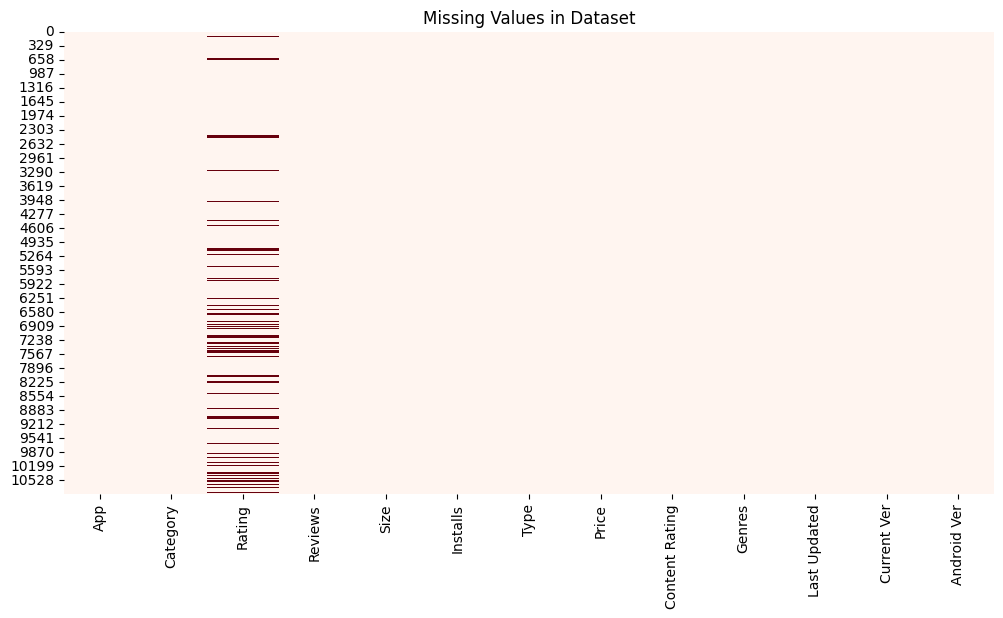

In [86]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, cmap='Reds') #df.isnull()  создаёт DataFrame из True/False, где True = пропущено (NaN)
plt.title("Missing Values in Dataset")
plt.show()


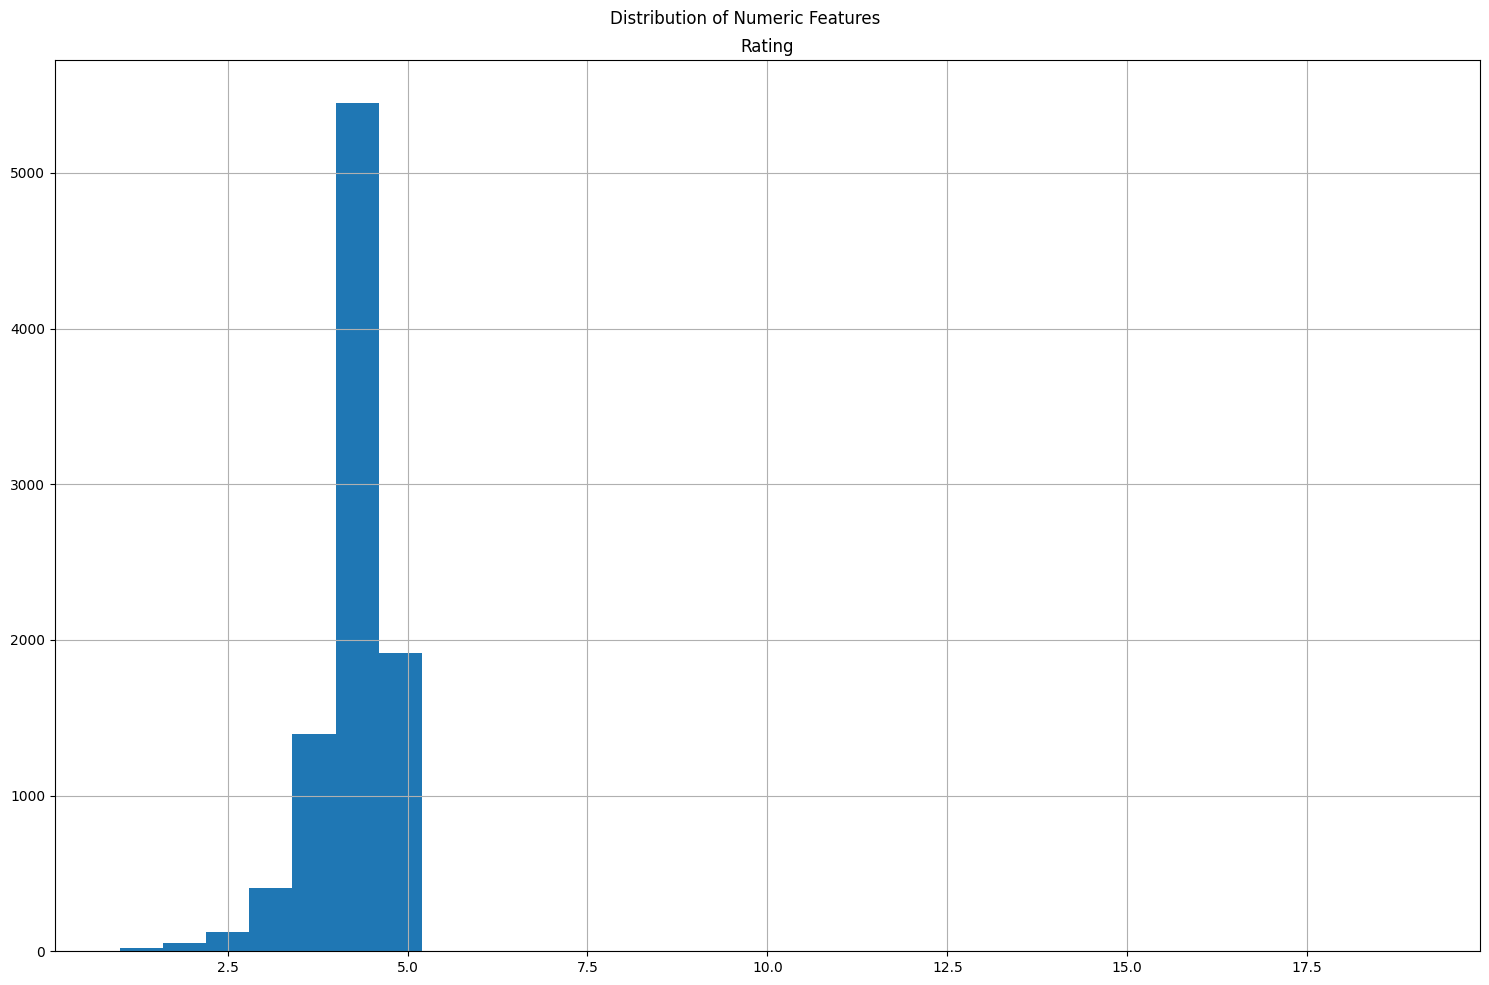

In [87]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

df[numeric_cols].hist(figsize=(15,10), bins=30)
plt.suptitle("Distribution of Numeric Features")
plt.tight_layout()
plt.show()


Тут ищу выбросы(outliers)
Boxplot показывает:

Медиану (линия внутри ящика)

25-й и 75-й перцентиль (границы ящика)

"Усы" — значения, лежащие в пределах 1.5 * IQR (межквартильного размаха)

Выбросы — точки за пределами усов (маленькие кружочки)

 нужно чтобы визуально оценить распределение числовых признаков и найти:

выбросы (outliers)

асимметрию

возможную нормализацию / лог-преобразование

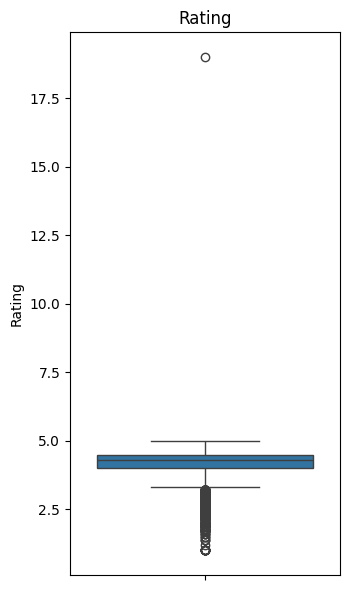

In [88]:
plt.figure(figsize=(15, 6))
for i, col in enumerate(numeric_cols[:5], 1):  # первые 5 признаков
    plt.subplot(1, 5, i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


                                           App Category  Rating Reviews  \
10472  Life Made WI-Fi Touchscreen Photo Frame      1.9    19.0    3.0M   

         Size Installs Type     Price Content Rating             Genres  \
10472  1,000+     Free    0  Everyone            NaN  February 11, 2018   

      Last Updated Current Ver Android Ver  
10472       1.0.19  4.0 and up         NaN  


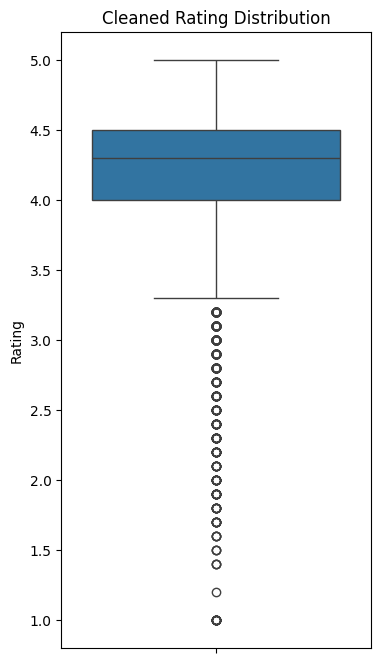

In [89]:
# Посмотрим значения больше 5 (что не должно быть в рейтинге)
bad_ratings = df[df['Rating'] > 5]
print(bad_ratings)
# Фильтруем только корректные рейтинги (от 1 до 5)
df_clean = df[(df['Rating'] >= 1) & (df['Rating'] <= 5)]
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 8))
sns.boxplot(y=df_clean['Rating'])
plt.title("Cleaned Rating Distribution")
plt.show()



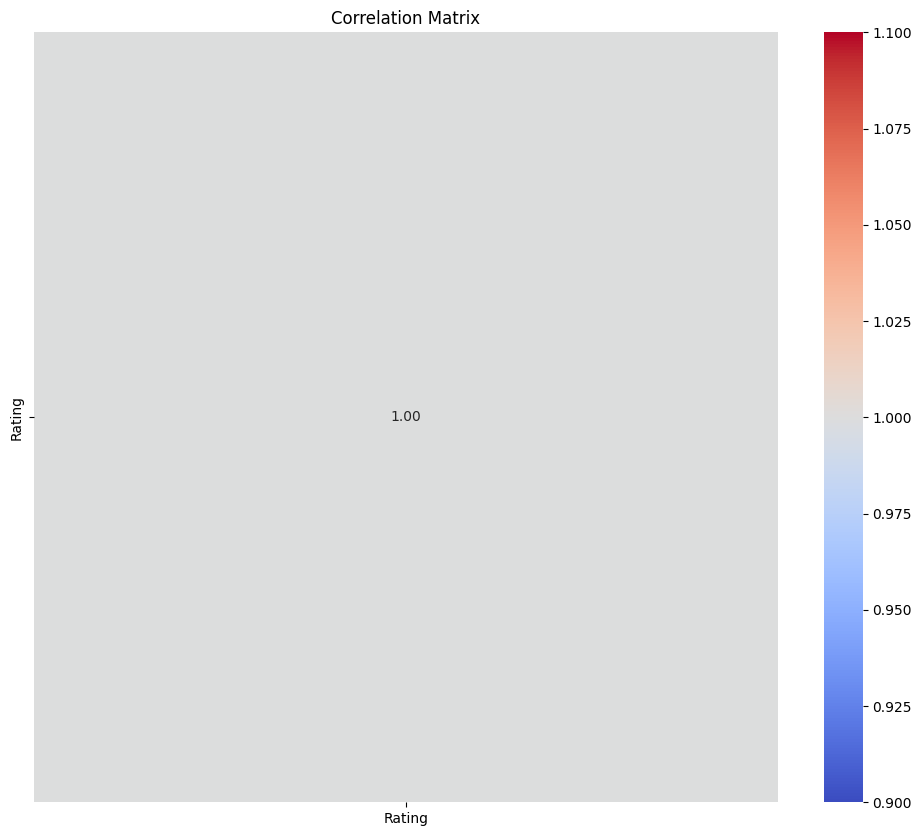

In [90]:
plt.figure(figsize=(12,10))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()


тут так потому что рейтинг единственный нумерикал

preparing data

In [91]:
# Проверим сколько значений стали NaN при попытке конвертации
price_before = df['Price'].copy()

# Попробуем привести к числам, а некорректные сделаем NaN
price_converted = pd.to_numeric(price_before, errors='coerce')

# Посчитаем сколько значений стали NaN
num_invalid = price_converted.isna().sum()
total = len(price_before)

print(f"Некорректных значений: {num_invalid} из {total} ({num_invalid / total * 100:.2f}%)")





# Удаляем строки, где пропущены важные поля
df = df.dropna(subset=['Rating', 'Installs', 'Type', 'Content Rating'])

# Остальное заполняем
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce') #ревьюс в числа
df['Reviews'] = df['Reviews'].fillna(df['Reviews'].median())# там где пропущенно ставлю медиану

df['Size'] = df['Size'].replace('Varies with device', np.nan) #эти мне не нравятся так что я убираю их чтобы потом заменить
#дальше тут работа с ценой

df['Price'] = df['Price'].fillna('0') # там где пропуски будет ноль

#функция чтобы преобразовать миллионы тысячи которы в буквах
def parse_size(size):
    if isinstance(size, str):
        size = size.strip()
        if size.endswith('M'):
            return float(size[:-1])
        elif size.endswith('k'):
            return float(size[:-1]) / 1024
    return np.nan

df['Size'] = df['Size'].apply(parse_size)
df['Size'] = df['Size'].fillna(df['Size'].median())  # заполняем медианой

df['Price'] = df['Price'].str.replace('$', '', regex=True) #нафиг знак доллара
df['Price'] = pd.to_numeric(df['Price'], errors='coerce').fillna(0.0)#некорректные значения будут 00 и еще преобразует в числа



# Быстрый обзор
df.info()
df.describe()
df.head()





# Проверим сколько значений стали NaN при попытке конвертации
price_before = df['Price'].copy()

# Попробуем привести к числам, а некорректные сделаем NaN
price_converted = pd.to_numeric(price_before, errors='coerce')

#  сколько значений стали NaN
num_invalid = price_converted.isna().sum()
total = len(price_before)

print(f"Некорректных значений: {num_invalid} из {total} ({num_invalid / total * 100:.2f}%)")




Некорректных значений: 801 из 10841 (7.39%)
<class 'pandas.core.frame.DataFrame'>
Index: 9366 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             9366 non-null   object 
 1   Category        9366 non-null   object 
 2   Rating          9366 non-null   float64
 3   Reviews         9366 non-null   int64  
 4   Size            9366 non-null   float64
 5   Installs        9366 non-null   object 
 6   Type            9366 non-null   object 
 7   Price           9366 non-null   float64
 8   Content Rating  9366 non-null   object 
 9   Genres          9366 non-null   object 
 10  Last Updated    9366 non-null   object 
 11  Current Ver     9362 non-null   object 
 12  Android Ver     9364 non-null   object 
dtypes: float64(3), int64(1), object(9)
memory usage: 1.0+ MB
Некорректных значений: 0 из 9366 (0.00%)


In [92]:
# Чистим скачивания от плюсов
df['Installs'] = df['Installs'].str.replace('[+,]', '', regex=True).astype(int)

# столбец успешности
def get_success_level(installs):
    if installs <= 10000:
        return 'Not Successful'
    elif installs <= 100000:
        return 'Average'
    elif installs <= 1000000:
        return 'Above Average'
    else:
        return 'Successful'

df['Success_Level'] = df['Installs'].apply(get_success_level)

# Кодируем метки
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Success_Level_Encoded'] = le.fit_transform(df['Success_Level'])
#ненужное
df = df.drop(columns=['App', 'Last Updated', 'Current Ver', 'Android Ver'])




In [93]:
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 9366 entries, 0 to 10840
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Category               9366 non-null   object 
 1   Rating                 9366 non-null   float64
 2   Reviews                9366 non-null   int64  
 3   Size                   9366 non-null   float64
 4   Installs               9366 non-null   int64  
 5   Type                   9366 non-null   object 
 6   Price                  9366 non-null   float64
 7   Content Rating         9366 non-null   object 
 8   Genres                 9366 non-null   object 
 9   Success_Level          9366 non-null   object 
 10  Success_Level_Encoded  9366 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 878.1+ KB


,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Success_Level,Success_Level_Encoded
0,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,Art & Design,Not Successful,2
1,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,Above Average,0
2,ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design,Successful,3
3,ART_AND_DESIGN,4.5,215644,25.0,50000000,Free,0.0,Teen,Art & Design,Successful,3
4,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0.0,Everyone,Art & Design;Creativity,Average,1


In [94]:
'''features = ['Category', 'Rating', 'Reviews', 'Size', 'Type', 'Price', 'Content Rating']
target = 'Success_Level_Encoded'

X = df[features]
y = df[target]
'''

"features = ['Category', 'Rating', 'Reviews', 'Size', 'Type', 'Price', 'Content Rating']\ntarget = 'Success_Level_Encoded'\n\nX = df[features]\ny = df[target]\n"

In [95]:
'''from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_features = ['Category', 'Type', 'Content Rating']
numeric_features = ['Rating', 'Reviews', 'Size', 'Price']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])
'''

"from sklearn.compose import ColumnTransformer\nfrom sklearn.preprocessing import OneHotEncoder, StandardScaler\n\ncategorical_features = ['Category', 'Type', 'Content Rating']\nnumeric_features = ['Rating', 'Reviews', 'Size', 'Price']\n\npreprocessor = ColumnTransformer(transformers=[\n    ('num', StandardScaler(), numeric_features),\n    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)\n])\n"

In [96]:
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 9366 entries, 0 to 10840
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Category               9366 non-null   object 
 1   Rating                 9366 non-null   float64
 2   Reviews                9366 non-null   int64  
 3   Size                   9366 non-null   float64
 4   Installs               9366 non-null   int64  
 5   Type                   9366 non-null   object 
 6   Price                  9366 non-null   float64
 7   Content Rating         9366 non-null   object 
 8   Genres                 9366 non-null   object 
 9   Success_Level          9366 non-null   object 
 10  Success_Level_Encoded  9366 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 878.1+ KB


,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Success_Level,Success_Level_Encoded
0,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,Art & Design,Not Successful,2
1,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,Above Average,0
2,ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design,Successful,3
3,ART_AND_DESIGN,4.5,215644,25.0,50000000,Free,0.0,Teen,Art & Design,Successful,3
4,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0.0,Everyone,Art & Design;Creativity,Average,1


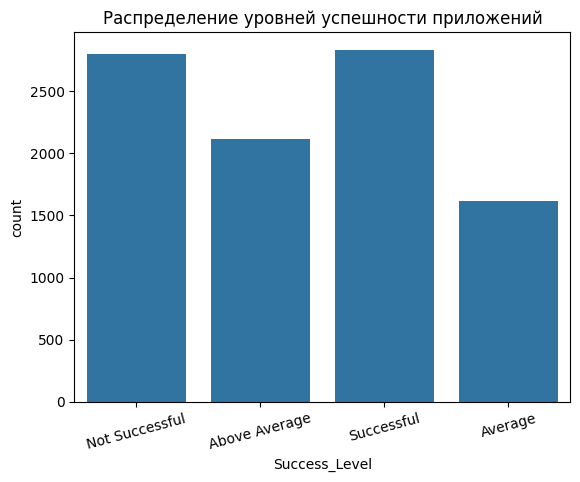

Success_Level_Encoded
3    2832
2    2802
0    2115
1    1617
Name: count, dtype: int64

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='Success_Level')
plt.title('Распределение уровней успешности приложений')
plt.xticks(rotation=15)
plt.show()

df['Success_Level'].value_counts()
df['Success_Level_Encoded'].value_counts()


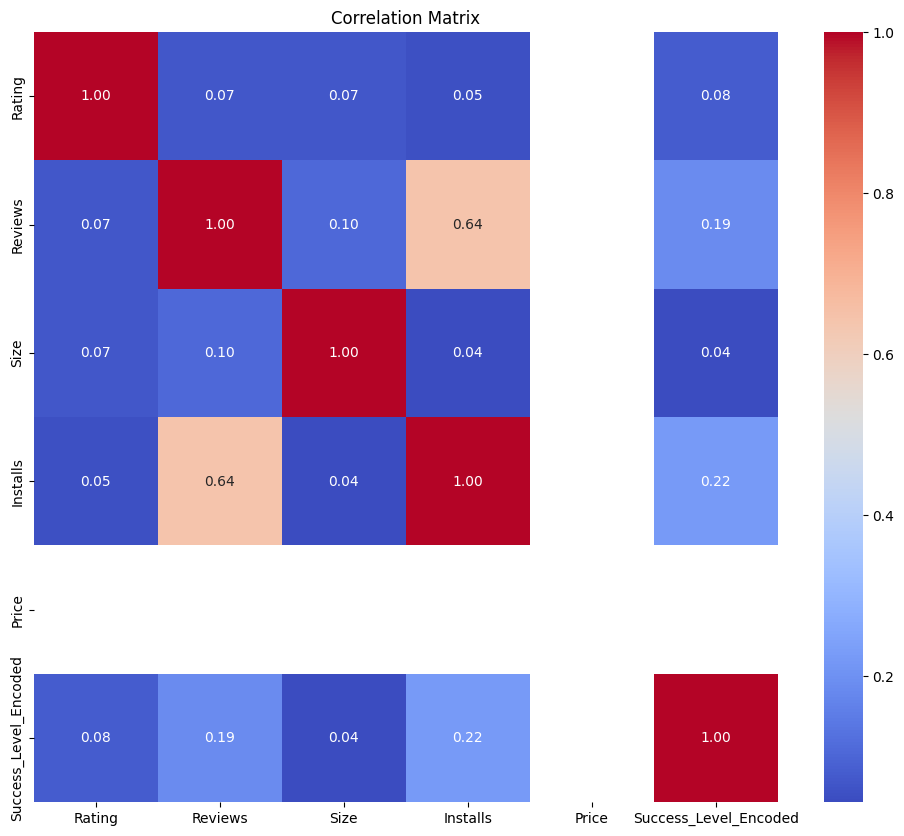

In [98]:
#check correlation again
plt.figure(figsize=(12,10))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()


In [99]:
from sklearn.model_selection import train_test_split

# Целевая переменная и признаки
X = df.drop(['Success_Level', 'Success_Level_Encoded'], axis=1)
y = df['Success_Level_Encoded']

# One-hot encoding для категориальных признаков
X = pd.get_dummies(X)

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [100]:
# Проверяем размер данных
print(f"Размер X_train: {X_train.shape}")
print(f"Размер X_test: {X_test.shape}")
print(f"Размер y_train: {y_train.shape}")
print(f"Размер y_test: {y_test.shape}")

# Проверяем первые несколько строк данных
print(X.head())

# Проверяем, сколько новых признаков было создано после one-hot encoding
print(f"Количество признаков после one-hot encoding: {X.shape[1]}")
# Проверяем наличие NaN в данных
print(f"Количество NaN в X_train: {X_train.isnull().sum().sum()}")
print(f"Количество NaN в X_test: {X_test.isnull().sum().sum()}")
# Проверяем баланс классов в целевой переменной
print(y.value_counts())


Размер X_train: (7492, 161)
Размер X_test: (1874, 161)
Размер y_train: (7492,)
Размер y_test: (1874,)
   Rating  Reviews  Size  Installs  Price  Category_ART_AND_DESIGN  \
0     4.1      159  19.0     10000    0.0                     True   
1     3.9      967  14.0    500000    0.0                     True   
2     4.7    87510   8.7   5000000    0.0                     True   
3     4.5   215644  25.0  50000000    0.0                     True   
4     4.3      967   2.8    100000    0.0                     True   

   Category_AUTO_AND_VEHICLES  Category_BEAUTY  Category_BOOKS_AND_REFERENCE  \
0                       False            False                         False   
1                       False            False                         False   
2                       False            False                         False   
3                       False            False                         False   
4                       False            False                         False 

logistic regression

Логистическая регрессия (Logistic Regression) — это модель классификации, которая предсказывает вероятность принадлежности объекта к определённому классу. Она хорошо подходит как для бинарных, так и для многоклассовых задач.

В моём случае используется многоклассовая логистическая регрессия, потому что целевая переменная (Success_Level_Encoded) содержит четыре разных класса. Модель автоматически применяет стратегию "multinomial", то есть обучается сразу для всех классов, а не по одному против остальных. Это обеспечивает более точное разделение между несколькими категориями


Как работает логистическая регрессия (многоклассовая):
Каждая строка данных (приложение) представляется в виде набора чисел — признаков (размер, рейтинг, цена и т.д.).

Модель учится находить зависимости между этими признаками и уровнями успешности (Success_Level_Encoded: 0, 1, 2, 3).

Для многоклассовой задачи логистическая регрессия использует метод "softmax" — он рассчитывает вероятность принадлежности к каждому классу.

Пример:
Для одного приложения модель может предсказать:

Класс 0: 5%

Класс 1: 15%

Класс 2: 30%

Класс 3: 50%
→ Значит, модель выберет класс 3 как итоговую метку.

В процессе обучения модель регулирует свои коэффициенты, чтобы как можно точнее разделить данные по классам.

In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logreg = LogisticRegression(max_iter=1000)#происходит 1000 итераций
logreg.fit(X_train, y_train)#обучение модели
y_pred_log = logreg.predict(X_test)
'''Эта строка выводит детальный отчет о качестве модели. Он включает несколько метрик для каждого класса:
Precision: точность (доля верных положительных предсказаний от всех предсказанных положительных).
Recall: полнота (доля верных положительных предсказаний от всех реальных положительных).
F1-score: гармоническое среднее между precision и recall, это сбалансированная метрика.
Support: количество экземпляров в каждом классе в тестовой выборке.'''

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_log))


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.77      0.94      0.85       403
           1       0.70      0.64      0.67       333
           2       0.97      0.87      0.92       569
           3       0.99      0.98      0.99       569

    accuracy                           0.88      1874
   macro avg       0.86      0.86      0.86      1874
weighted avg       0.89      0.88      0.88      1874



c:\Users\111\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SVM

In [102]:
from sklearn.svm import SVC

svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("SVM Report:")
print(classification_report(y_test, y_pred_svm))


SVM Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       403
           1       0.00      0.00      0.00       333
           2       0.44      1.00      0.61       569
           3       1.00      1.00      1.00       569

    accuracy                           0.61      1874
   macro avg       0.36      0.50      0.40      1874
weighted avg       0.44      0.61      0.49      1874



c:\Users\111\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\111\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\111\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

polynomial
короче тут оно не выдавало результат 10 минут и может больше потому что degree было 2 , я постаивла 1 и все лучше
(надо разораться как этот дегри работает)

In [107]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Целевая переменная и признаки
X = df.drop(['Success_Level', 'Success_Level_Encoded'], axis=1)
y = df['Success_Level_Encoded']

# One-hot encoding для категориальных признаков
X = pd.get_dummies(X)

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Создание полиномиальных признаков (например, степень 2)
poly = PolynomialFeatures(degree=1)

# Преобразование обучающих и тестовых данных
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Модель логистической регрессии с мульти-номинальной настройкой
logreg = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
logreg.fit(X_train_poly, y_train)

# Предсказания
y_pred = logreg.predict(X_test_poly)

# Отчет о качестве модели
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred))


c:\Users\111\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       403
           1       0.71      0.65      0.68       333
           2       0.97      0.88      0.92       569
           3       0.99      0.99      0.99       569

    accuracy                           0.88      1874
   macro avg       0.86      0.86      0.86      1874
weighted avg       0.89      0.88      0.88      1874



c:\Users\111\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
